# Long-term forecasting of volatility
## This notebook is about forecasting of volatility using GARCH models. First, we will try to simulate a GARCH time series, than fit a GARCH model to it and forecast future volatility. Then we will try to compare the results with a SVR model. 
## After that we will apply both model to the real market data.

In [4]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error
import time
import math
from sklearn.exceptions import DataConversionWarning
from sklearn import svm
from scipy import stats
import random
import sklearn
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error 
import warnings 
warnings.filterwarnings('ignore')
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [2]:
# function for simulations of garch(1,1) process 
def simulate_GARCH(N, omega, alpha, beta=0):
    
    a0 = omega
    a1 = alpha
    b1 = beta

    n = N
    w = np.random.normal(size=n)
    eps = np.zeros_like(w)
    sigsq = np.zeros_like(w)

    for i in range(1, n):
        sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
        eps[i] = w[i] * np.sqrt(sigsq[i])
    
    return eps, np.sqrt(sigsq)

In [3]:
# simulations of garch(2,2)
def simulate_GARCH_mod(n, omega, alpha1, alpha2, beta1=0, beta2=0):
    
    # Initialize our values
    sigma1 = 0.1
    X = np.ndarray(n)
    sigma = np.ndarray(n)
    sigma[0], sigma[1] = sigma1, sigma1
    X[0], X[1] = sigma1, sigma1
    for t in range(2, n):
        # Draw the next x_t
        X[t - 1] = sigma[t - 1] * np.random.normal(0, 1)
        # Draw the next sigma_t
        sigma[t] = math.sqrt(omega+beta1*sigma[t-1]**2+beta2*sigma[t-2]**2+alpha1*X[t-1]**2+alpha2*X[t-2]**2)
        
    X[n - 1] = sigma[n - 1] * np.random.normal(0, 1)    
    
    return X, sigma

## In the case of GARCH(1,1) for prediction for horizon h we use formula :
## $E_{t-1} [\sigma^2_{t+h}] = \omega* \sum_{i=0}^{h-1}(\alpha+\beta)^i + (\alpha+\beta)^h*\sigma_t^2 = \omega*\frac{1-(\alpha+\beta)^{h-1}}{1-\alpha - \beta} + (\alpha+\beta)^h*\sigma_t^2$
## In the case of GARCH(2,2) for prediction for horizon h we use formula :
## $E_{t-1} [\sigma^2_{t+h}] = \omega* \sum_{i=0}^{h-1}(\alpha_1+\beta_1)^i + (\alpha_1+\beta_1)^h*\sigma_t^2+  \omega* \sum_{i=0}^{h-2}(\alpha_2+\beta_2)^i + (\alpha_2+\beta_2)^{h-1}*\sigma_t^2  = \omega*\frac{1-(\alpha_1+\beta_1)^{h-1}}{1-\alpha_1 - \beta_1} + (\alpha_1+\beta_1)^h*\sigma_t^2+\omega*\frac{1-(\alpha_2+\beta_2)^{h-2}}{1-\alpha_2 - \beta_2} + (\alpha_2+\beta_2)^{h-1}*\sigma_t^2$

# SVR

In [4]:
l = int(5000-15)*0.8
l

3988.0

### The reference of this code is $\href{https://github.com/danielgy/Time-Series-Forecasting}{source}$

In [5]:
def predict_ts(sigma, h):
    # predict square of returns
    l = int(len(sigma)-15)*0.8
    sigma_train, sigma_test =  np.power(sigma[:3988],2), np.power(sigma[3988:],2)
    # reshape to an appropriate forma
    sigma_train = sigma_train.reshape(-1, 1)
    sigma_test = sigma_test.reshape(-1,1)
    
    # scaling to ensure the data is projected in the interval 0,1.
    scaler = MinMaxScaler()
    sigma_train = scaler.fit_transform(sigma_train)
    X_train = sigma_train[:3988-h]
    y_train= sigma_train[h:]
    X_test = sigma_test[:997-h]
    y_test = sigma_test[h:]
    
    warnings.filterwarnings('ignore', category=DataConversionWarning)
    
    param_grid = {'C': [0.1, 1], 'gamma': [1,'auto', 'scale', 10],'kernel': ['rbf','poly', 'sigmoid']}
    grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=1)
    grid.fit(X_train,y_train)
    svr = grid.best_estimator_

    svr.fit(X_train,y_train)
    p = svr.predict(X_test)
    predictions = scaler.inverse_transform(np.array(p).reshape(-1, 1))
    error = mean_squared_error(y_test, predictions)
    return error

In [6]:
def garch22(ret, sigma, h):
    l = int(len(sigma)-15)*0.8
    ret_train, ret_test, sigma_train, sigma_test = ret[:3988],ret[3988:], sigma[:3988],sigma[3988:]
    pred = []
    real = []
    k = len(ret_test)
    warnings.filterwarnings('ignore')
     # fit a built-in function to estimate coefficients 
    garch = arch_model(ret_train, p=2, q=2).fit(disp='off')
    #read coefficients 
    omega,a1,b1,a2,b2 = (garch.params['omega'], garch.params['alpha[1]'],
                              garch.params['beta[1]'], garch.params['alpha[2]'], garch.params['beta[2]'])
    
    for i in range(k):

        #calculate sigma square
        pred_sigma2 =(omega* ((1-np.power(a1+b1, h-1))/(1-a1-b1)+(1-np.power(a2+b2, h-2))/(1-a2-b2))
                      + np.power(a1+b1,h)* sigma_train[-h]**2 + np.power(a2+b2,h-2)* sigma_train[-h]**2)
        
        pred.append(pred_sigma2)
        real.append(sigma_test[0]**2)
        
        ret_train = np.append(ret_train, ret_test[0])
        ret_test = np.delete(ret_test, [0])
        sigma_train = np.append(sigma_train, sigma_test[0])
        sigma_test = np.delete(sigma_test, [0])

    mse_garch2 = mean_squared_error(pred, real)
    
    return mse_garch2

In [7]:
def garch11(ret, sigma, h):
    l = int(len(sigma)-15)*0.8
    ret_train, ret_test, sigma_train, sigma_test = ret[:3988],ret[3988:], sigma[:3988],sigma[3988:]

    pred = []
    real = []
    k = len(ret_test)
    # fit a built-in function to estimate coefficients 
    garch = arch_model(ret_train, p=1, q=1).fit(disp='off')
    #read coefficients 
    omega,a1,b1 = garch.params['omega'], garch.params['alpha[1]'], garch.params['beta[1]']
    
    
    for i in range(k):

        #calculate sigma square
        pred_sigma2 = omega* (1-np.power(a1+b1, h-1))/(1-a1-b1) + np.power(a1+b1,h)* sigma_train[-h]**2
        
        pred.append(pred_sigma2)
        real.append(sigma_test[0]**2)
        #print(pred_sigma2, sigma_test[0]**2)
        ret_train = np.append(ret_train, ret_test[0])
        ret_test = np.delete(ret_test, [0])
        sigma_train = np.append(sigma_train, sigma_test[0])
        sigma_test = np.delete(sigma_test, [0])



    mse_garch1 = mean_squared_error(pred,real)
    return mse_garch1

# Сompare models on 1 simulated series of GARCH(1,1)

In [23]:
err_1 = []
err_2 = []
err_svr = []
ret,sigma = simulate_GARCH(N=5000, omega=0.01, alpha=0.15, beta=0.65)
ret = ret[15:]
sigma = sigma[15:]

for h in range(2,25):
    err_1.append(garch11(ret, sigma, h))
    err_2.append(garch22(ret, sigma, h))
    err_svr.append(predict_ts(sigma,h))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 

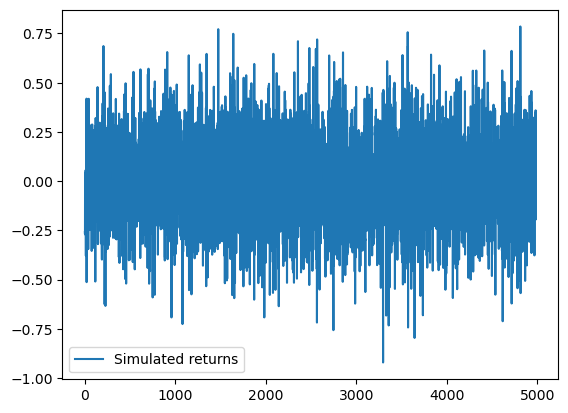

In [24]:
plt.plot(ret[0:], label='Simulated returns')
plt.legend()
plt.show()

In [25]:
len(err_1)

23

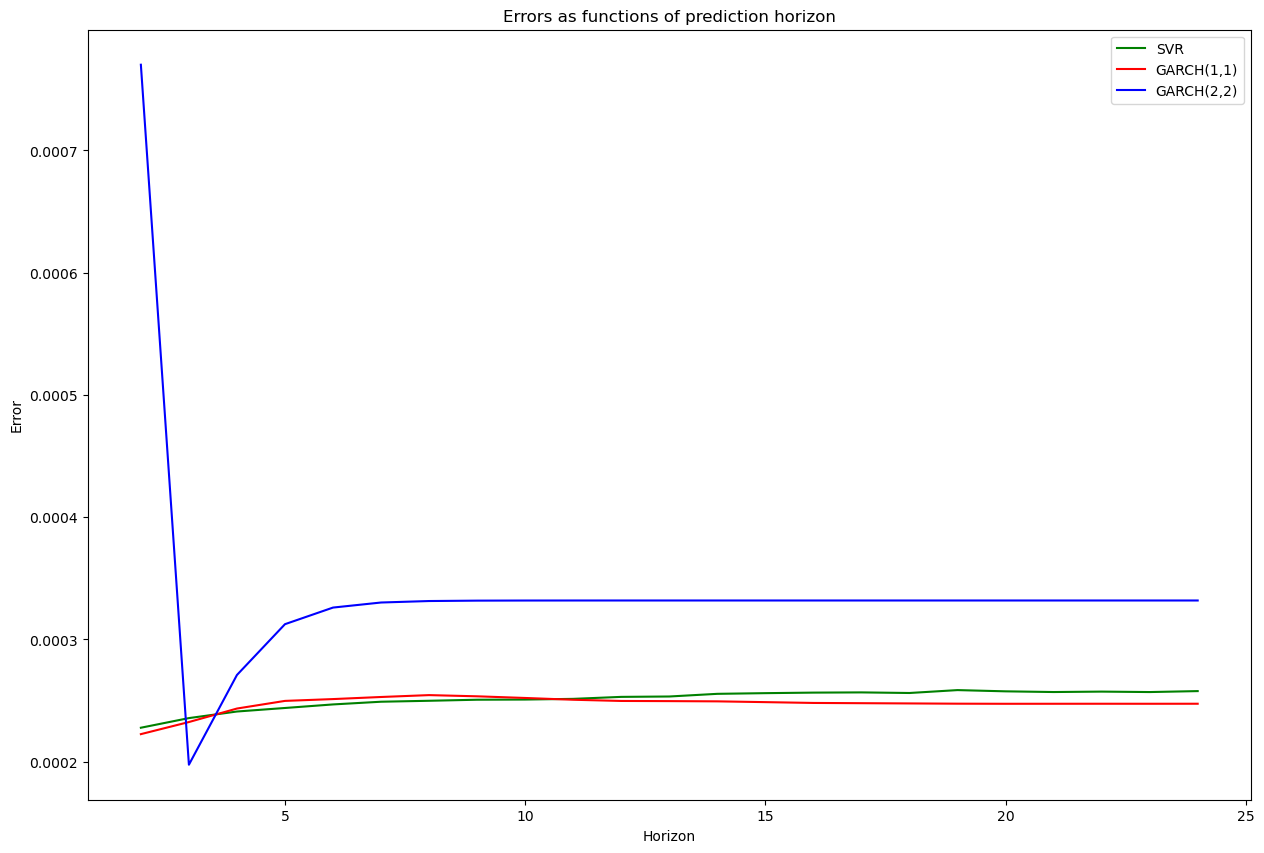

In [26]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),err_svr,color='green', label='SVR') 
plt.plot(range(2,25),err_1,color='red', label="GARCH(1,1)") 
plt.plot(range(2,25),err_2,color='blue', label="GARCH(2,2)") 
plt.title('Errors as functions of prediction horizon') 
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

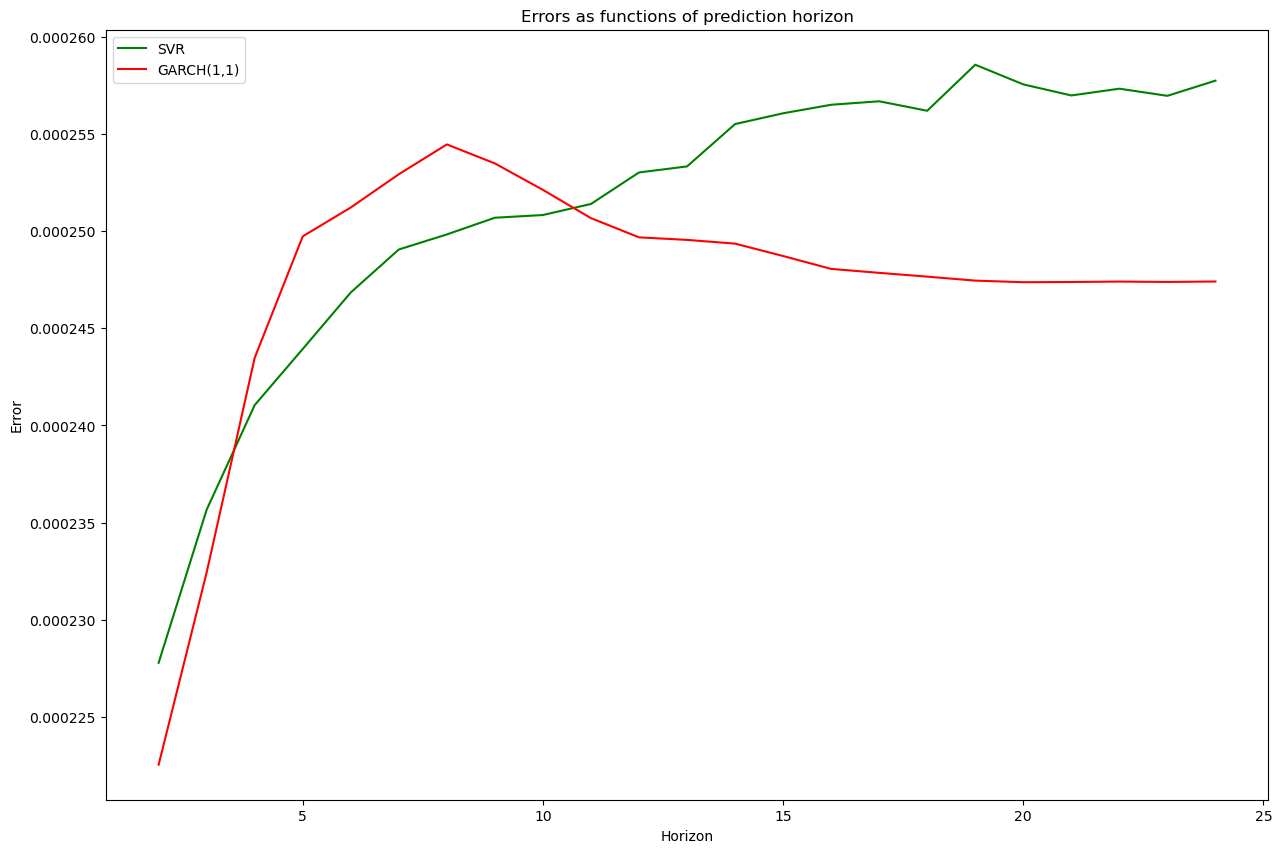

In [27]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),err_svr,color='green', label='SVR') 
plt.plot(range(2,25),err_1,color='red', label="GARCH(1,1)") 
plt.title('Errors as functions of prediction horizon') 
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

## Мы можем видеть, что некорректно специфицированный GARCH(2,2) проявляет себя хуже всего, в то время как GARCH(1,1) показывает наименьшую ошибку почти на всех горизонтах прогнозирования. Метод машинного обучения SVR же ведет себя почти также хорошо, как GARCH(1,1)

# Сompare models on 10 simulated series of GARCH(1,1)

In [28]:
err_11 = []
err_21 = []
err_svr1 = []
    
err_1h = []
err_2h = []
err_svrh = []

error_count = 0
for i in range(10):
    try:
        ret,sigma = simulate_GARCH(N=5000, omega=0.01, alpha=0.15, beta=0.65)
        ret = ret[15:]
        sigma = sigma[15:]
        for h in range(2,25):
            err_1h.append(garch11(ret, sigma, h))
            err_2h.append(garch22(ret, sigma, h))
            err_svrh.append(predict_ts(sigma,h))

        err_11.append(err_1h)
        err_21.append(err_2h)
        err_svr1.append(err_svrh)

        err_1h = []
        err_2h = []
        err_svrh = []
    
    except ValueError as e:
        error_count+=1
        pass

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 

In [29]:
k = 10-error_count

In [30]:
len(err_11)

10

In [35]:
garch11_avr = np.zeros(23)
garch22_avr = np.zeros(23)
svr_avr = np.zeros(23)
bug_count = 0
for i in range(k):
    if  (np.array(err_11[i]).shape[0]) <= 23: 
        garch11_avr = np.add(garch11_avr, np.array(err_11[i]))
        garch22_avr = np.add(garch22_avr, err_21[i]) 
        svr_avr = np.add(svr_avr, err_svr1[i])
    else:
        bug_count+=1
    
    
garch11_avr = np.divide(garch11_avr,10-error_count-bug_count)
garch22_avr = np.divide(garch22_avr,10-error_count-bug_count)
svr_avr = np.divide(svr_avr,10-error_count-bug_count)

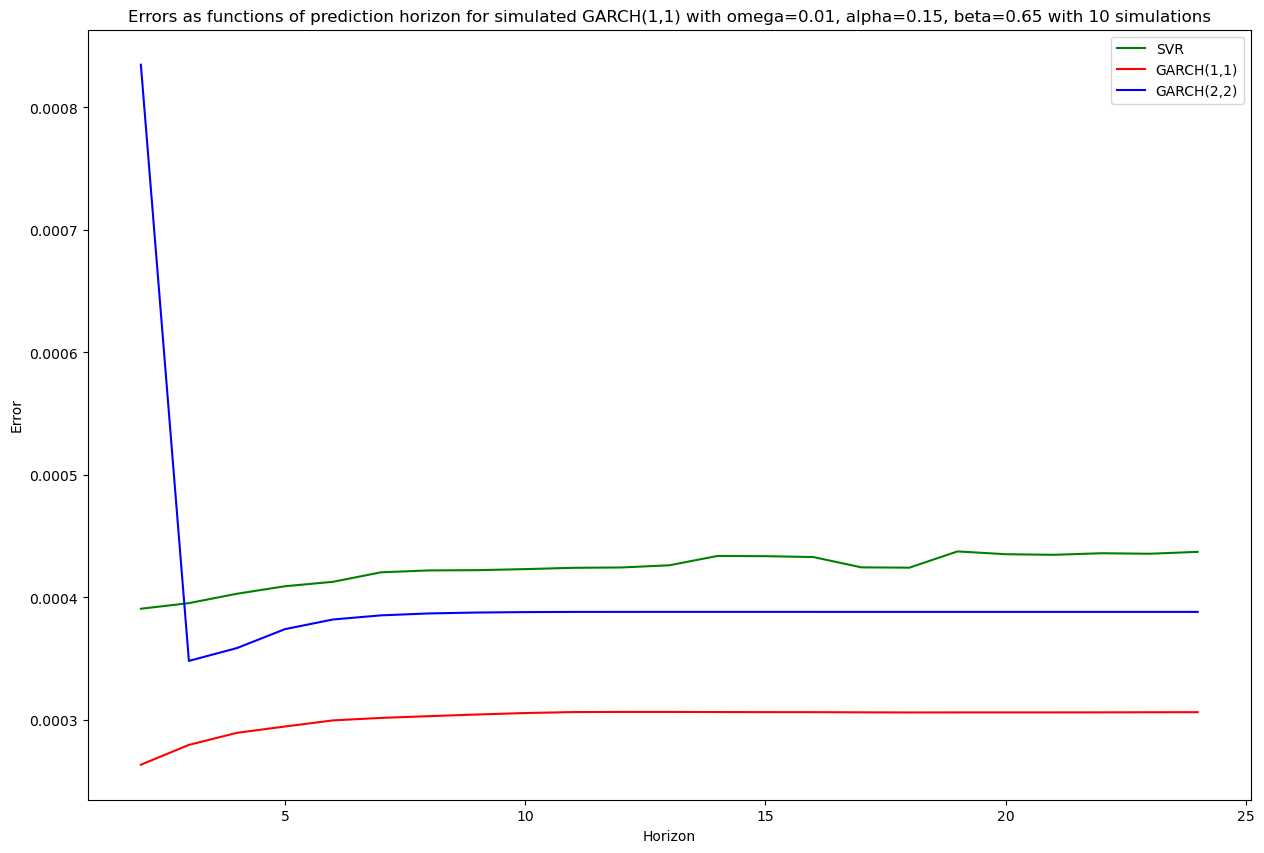

In [40]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),svr_avr,color='green', label='SVR') 
plt.plot(range(2,25),garch11_avr,color='red', label="GARCH(1,1)") 
plt.plot(range(2,25),garch22_avr,color='blue', label="GARCH(2,2)") 
plt.title('Errors as functions of prediction horizon for simulated GARCH(1,1) with omega=0.01, alpha=0.15, beta=0.65 with 10 simulations') 
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

## 

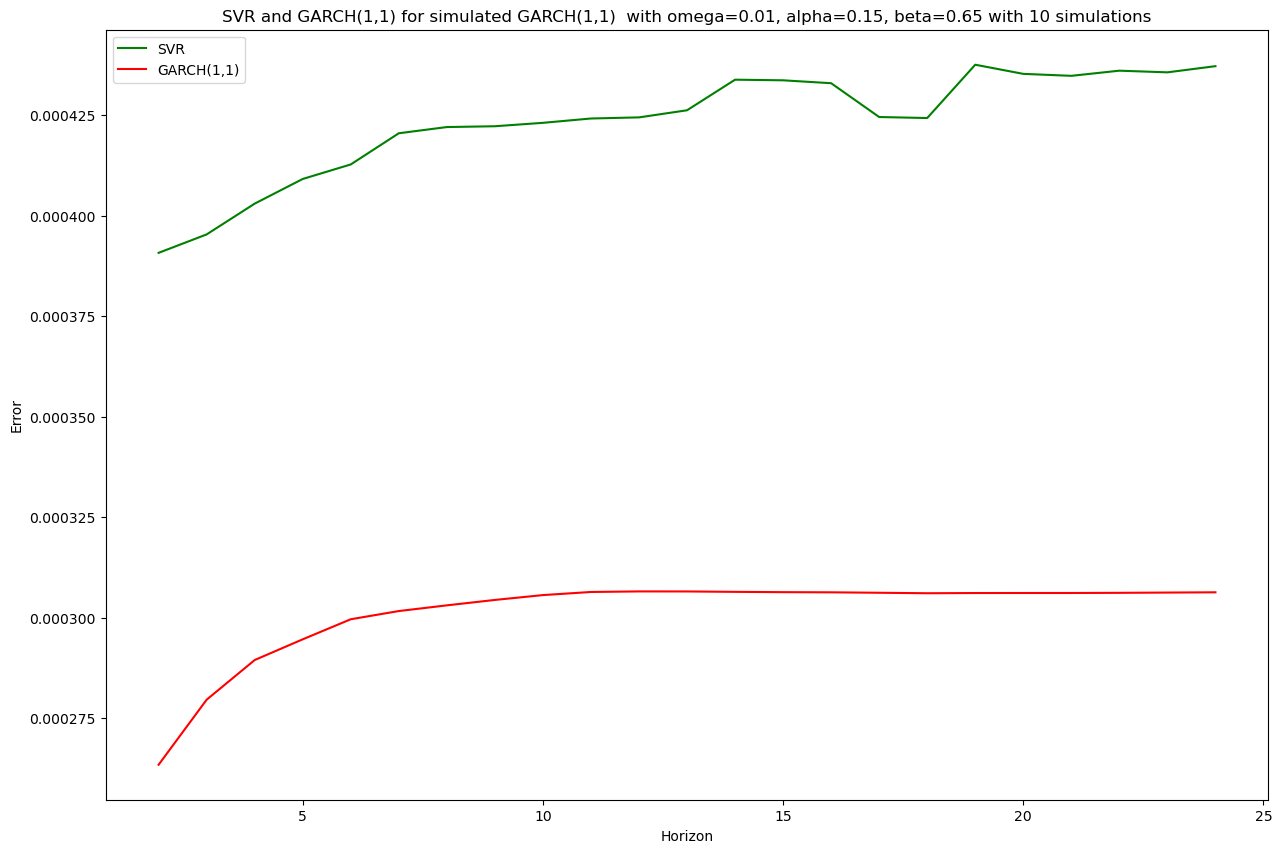

In [43]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),svr_avr,color='green', label='SVR') 
plt.plot(range(2,25),garch11_avr,color='red', label="GARCH(1,1)") 
plt.title('SVR and GARCH(1,1) for simulated GARCH(1,1)  with omega=0.01, alpha=0.15, beta=0.65 with 10 simulations') 
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

## It is surprising that the error is almost constant function of the prrediction horison for all models, because it would be logical if it had been increasing. In other aspects results are logical, the correctly specified GARCH is the best and misspesified is the worst.

# Сompare models on 10 simulated series of GARCH(2,2)

In [44]:
err_1 = []
err_2 = []
err_svr = []
    
err_1h = []
err_2h = []
err_svrh = []

error_count = 0
for i in range(10):
    try:
        ret,sigma = simulate_GARCH_mod(n=5000, omega=0.01, alpha1=0.025, alpha2 = 0.02, beta1=0.65, beta2=0.2)
        ret = ret[15:]
        sigma = sigma[15:]
        for h in range(2,25):
            err_1h.append(garch11(ret, sigma, h))
            err_2h.append(garch22(ret, sigma, h))
            err_svrh.append(predict_ts(ret,h))

        err_1.append(err_1h)
        err_2.append(err_2h)
        err_svr.append(err_svrh)

        err_1h = []
        err_2h = []
        err_svrh = []
    
    except ValueError as e:
        error_count+=1
        pass

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 

In [45]:
garch11_avr = np.zeros(23)
garch22_avr = np.zeros(23)
svr_avr = np.zeros(23)
bug_count = 0
for i in range(10-error_count):
    if  (np.array(err_1[i]).shape[0]) <= 23: 
        garch11_avr = np.add(garch11_avr, np.array(err_1[i]))
        garch22_avr = np.add(garch22_avr, err_2[i]) 
        svr_avr = np.add(svr_avr, err_svr[i])
    else:
        bug_count+=1
    
    
garch11_avr = np.divide(garch11_avr,10-error_count-bug_count)
garch22_avr = np.divide(garch22_avr,10-error_count-bug_count)
svr_avr = np.divide(svr_avr,10-error_count-bug_count)

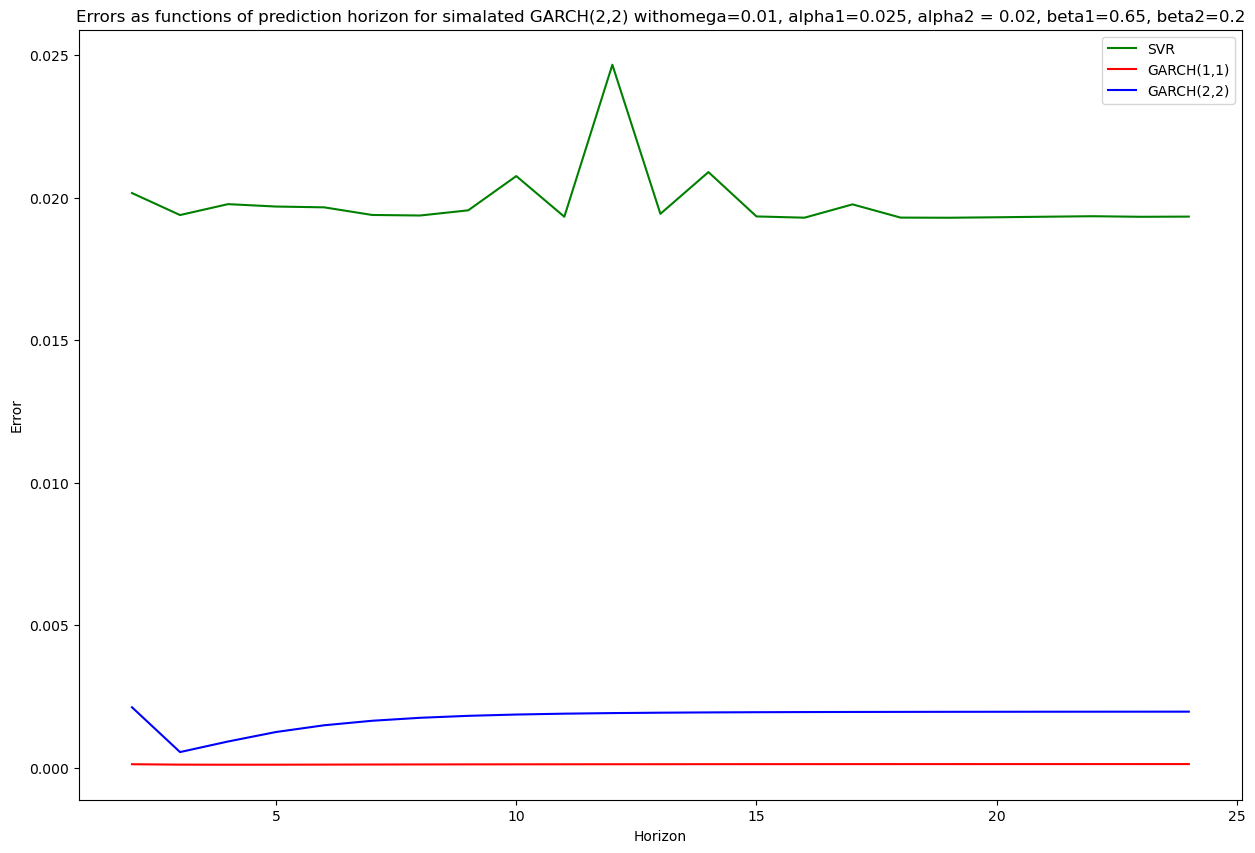

In [50]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),svr_avr,color='green', label='SVR') 
plt.plot(range(2,25),garch11_avr,color='red', label="GARCH(1,1)") 
plt.plot(range(2,25),garch22_avr,color='blue', label="GARCH(2,2)") 
plt.title('Errors as functions of prediction horizon for simalated GARCH(2,2) withomega=0.01, alpha1=0.025, alpha2 = 0.02, beta1=0.65, beta2=0.2')
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

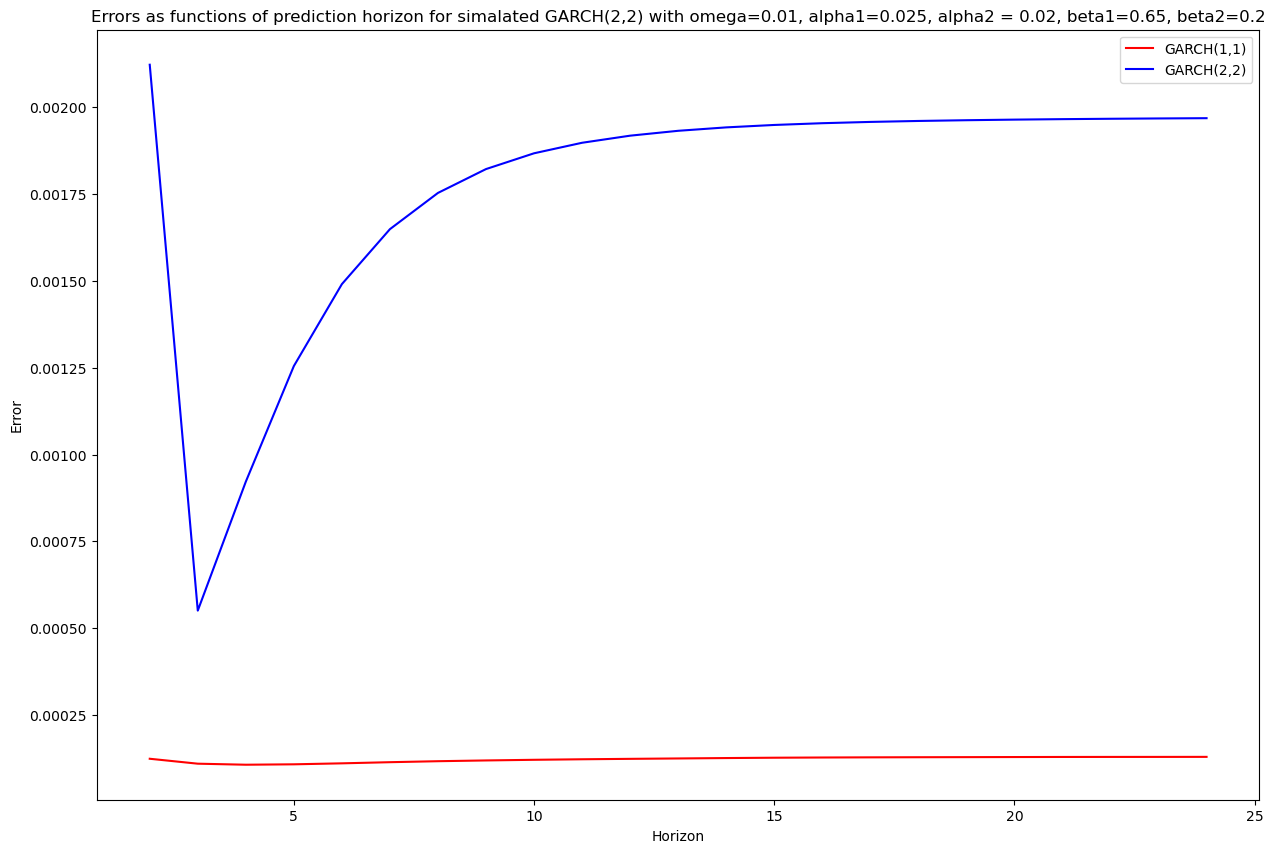

In [51]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),garch11_avr,color='red', label="GARCH(1,1)") 
plt.plot(range(2,25),garch22_avr,color='blue', label="GARCH(2,2)") 
plt.title('Errors as functions of prediction horizon for simalated GARCH(2,2) with omega=0.01, alpha1=0.025, alpha2 = 0.02, beta1=0.65, beta2=0.2')
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

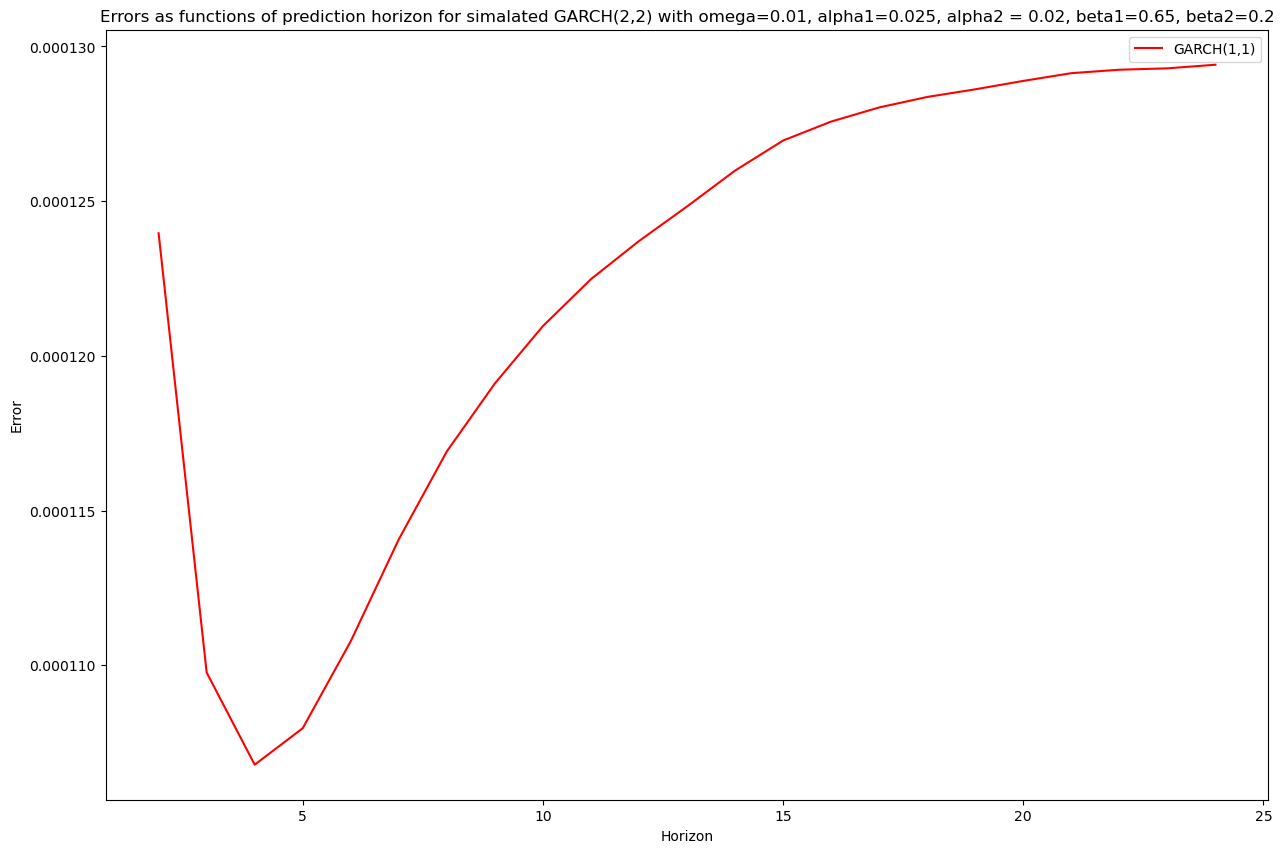

In [58]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),garch11_avr,color='red', label="GARCH(1,1)") 
plt.title('Errors as functions of prediction horizon for simalated GARCH(2,2) with omega=0.01, alpha1=0.025, alpha2 = 0.02, beta1=0.65, beta2=0.2')
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

# Applocation to real data

In [5]:
stocks = 'SPY'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2022, 1, 1)
data = yf.download(stocks, start=start, end = end, interval='1d')
data['returns'] = data.Close.pct_change().dropna()
data['vol_squared'] = data['returns']**2
data = data[1:]
data = data.reset_index(drop=True)

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/gosa/.local/lib/python3.9/site-packages/requests/models.py", line 971, in json
    return complexjson.loads(self.text, **kwargs)
  File "/Users/gosa/opt/anaconda3/lib/python3.9/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/Users/gosa/opt/anaconda3/lib/python3.9/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/Users/gosa/opt/anaconda3/lib/python3.9/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/gosa/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/gosa/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
   

KeyboardInterrupt: 

In [3]:
def get_sigma_prac(X, w, a1, b1, a2=0, b2=0):
    n = len(X)
    sigma1 = np.random.normal()**2
    sigma = np.ndarray(n)
    sigma[0], sigma[1] = sigma1, sigma1
    for t in range(2, n): 
        sigma[t] = math.sqrt(w+b1*sigma[t-1]**2+b2*sigma[t-2]**2+a1*X[t-1]**2+a2*X[t-2]**2)
    return sigma

In [64]:
X,s = simulate_GARCH_mod(n=5000, omega=0.01, alpha1=0.025, alpha2 = 0.02, beta1=0.65, beta2=0.2)

In [65]:
sigma = get_sigma_prac(X, w=0.01, a1=0.025, b1=0.65, a2= 0.02, b2=0.2)

In [66]:
print(mean_squared_error(s,sigma))

0.004569093384119963


In [1]:
def get_vol(ret):
    vol = np.array(len(ret))
    mean = ret.mean()
    for i in range(len(ret)):
        vol[i] = np.abs(ret[i]-mean)